### 정형 데이터 변수 1개

In [1]:
import pandas as pd

df = pd.read_csv('c:/workspace3/data/concrete.csv')
df.head()

,cement,flag,ash,water,superplastic,coarseagg,findagg,age,strength,class
0,164.2,0.0,200.1,181.2,12.6,849.3,846.0,28,15.09,0
1,164.0,0.0,200.0,181.0,13.0,849.0,846.0,28,15.09,0
2,158.0,0.0,195.0,220.0,11.0,898.0,713.0,28,8.54,0
3,144.0,15.0,195.0,176.0,6.0,1021.0,709.0,28,15.34,0
4,167.0,187.0,195.0,185.0,7.0,898.0,636.0,28,23.89,0


In [2]:
real_data=df['strength'].values
real_data

array([15.09, 15.09,  8.54, ..., 39.46, 37.92, 32.77])

In [3]:
from sklearn.preprocessing import MinMaxScaler

sc = MinMaxScaler()
scaled=sc.fit_transform(df[['strength']])
scaled[:10]
real_data=scaled
real_data

array([[0.1589635 ],
       [0.1589635 ],
       [0.0773639 ],
       ...,
       [0.46256385],
       [0.4433786 ],
       [0.37922013]])

In [6]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop

import numpy as np

# 모델 파라미터 설정
d_input=1 #변수의 개수
d_hidden = 256
d_output = 1

g_input = 32
g_hidden = 256
g_output = d_input

# fake 데이터 생성
def makeZ(m, n):
    z = np.random.uniform(-1.0, 1.0, size=[m, n])

    return z

def myOptimizer(lr):

    return RMSprop(learning_rate=lr)

# 판별 모델
def build_D():
    d_x = Input(batch_shape=(None, d_input))
    d_h = Dense(d_hidden, activation='relu')(d_x)
    d_o = Dense(d_output, activation='sigmoid')(d_h)   

    d_model = Model(d_x, d_o)
    d_model.compile(loss='binary_crossentropy', optimizer=myOptimizer(0.0001))

    return d_model

# 생성 모델
def build_G():
    g_x = Input(batch_shape=(None, g_input))
    g_h = Dense(g_hidden, activation='relu')(g_x)
    g_o = Dense(g_output, activation='linear')(g_h)
   
    g_model = Model(g_x, g_o)
    
    return g_model

# GAN 모델
def build_GAN(discriminator, generator):
    discriminator.trainable = False # 추론모드

    z = Input(batch_shape=(None, g_input))
    Gz = generator(z)
    DGz = discriminator(Gz)

    gan_model = Model(z, DGz)
    gan_model.compile(loss='binary_crossentropy', optimizer=myOptimizer(0.0005))

    return gan_model

In [7]:
real_data

array([[0.1589635 ],
       [0.1589635 ],
       [0.0773639 ],
       ...,
       [0.46256385],
       [0.4433786 ],
       [0.37922013]])

In [8]:
from tensorflow.keras import backend as K

# 학습
K.clear_session()

D = build_D() # discriminator
G = build_G() # generator
GAN = build_GAN(D, G) # GAN

In [9]:
D.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 dense (Dense)               (None, 256)               512       
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 769
Trainable params: 0
Non-trainable params: 769
_________________________________________________________________


In [10]:
G.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32)]              0         
                                                                 
 dense_2 (Dense)             (None, 256)               8448      
                                                                 
 dense_3 (Dense)             (None, 1)                 257       
                                                                 
Total params: 8,705
Trainable params: 8,705
Non-trainable params: 0
_________________________________________________________________


In [11]:
GAN.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32)]              0         
                                                                 
 model_1 (Functional)        (None, 1)                 8705      
                                                                 
 model (Functional)          (None, 1)                 769       
                                                                 
Total params: 9,474
Trainable params: 8,705
Non-trainable params: 769
_________________________________________________________________


In [12]:
n_batch_cnt = 3
n_batch_size = int( real_data.shape[0] / n_batch_cnt)
EPOCHS = 200

for epoch in range(EPOCHS):
    for n in range(n_batch_cnt):
        from_, to_ = n*n_batch_size, (n+1)*n_batch_size
        if n == n_batch_cnt -1 :
            to_ = real_data.shape[0]

        # mini batch
        X_batch = real_data.reshape(-1,1)[from_: to_]
        Z_batch = makeZ(m=X_batch.shape[0], n=g_input)
        Gz = G.predict(Z_batch) # 가짜 데이터로부터 분포 생성
        #print(Gz.shape)

        # 판별모형 학습 데이터 준비
        d_target = np.zeros(X_batch.shape[0]*2)
        d_target[:X_batch.shape[0]] = 1
        d_target[X_batch.shape[0]:] = 0        

        bX_Gz = np.concatenate([X_batch, Gz])

       # 생성모형 학습 데이터 준비
        g_target = np.zeros(Z_batch.shape[0])
        g_target[:] = 1

        # discriminator 학습        
        loss_D = D.train_on_batch(bX_Gz, d_target)

        # generator 학습        
        loss_G = GAN.train_on_batch(Z_batch, g_target)

    if epoch % 10 == 0:
        z = makeZ(m=real_data.shape[0], n=g_input)
        print("Epoch: %d, D-loss = %.4f, G-loss = %.4f" %(epoch, loss_D, loss_G))

11/11 [==============================] - 0s 704us/step
Epoch: 0, D-loss = 0.7068, G-loss = 0.6941
11/11 [==============================] - 0s 2ms/step
Epoch: 10, D-loss = 0.6866, G-loss = 0.7016
11/11 [==============================] - 0s 1ms/step
Epoch: 20, D-loss = 0.6882, G-loss = 0.6818
11/11 [==============================] - 0s 2ms/step
Epoch: 30, D-loss = 0.6939, G-loss = 0.6718
11/11 [==============================] - 0s 2ms/step
Epoch: 40, D-loss = 0.6937, G-loss = 0.6797
11/11 [==============================] - 0s 2ms/step
Epoch: 50, D-loss = 0.6933, G-loss = 0.6903
11/11 [==============================] - 0s 2ms/step
Epoch: 60, D-loss = 0.6932, G-loss = 0.6933
11/11 [==============================] - 0s 1ms/step
Epoch: 70, D-loss = 0.6932, G-loss = 0.6930
11/11 [==============================] - 0s 330us/step
Epoch: 80, D-loss = 0.6931, G-loss = 0.6930
11/11 [==============================] - 0s 1ms/step
Epoch: 90, D-loss = 0.6931, G-loss = 0.6938
11/11 [====================

33/33 [==============================] - 0s 2ms/step


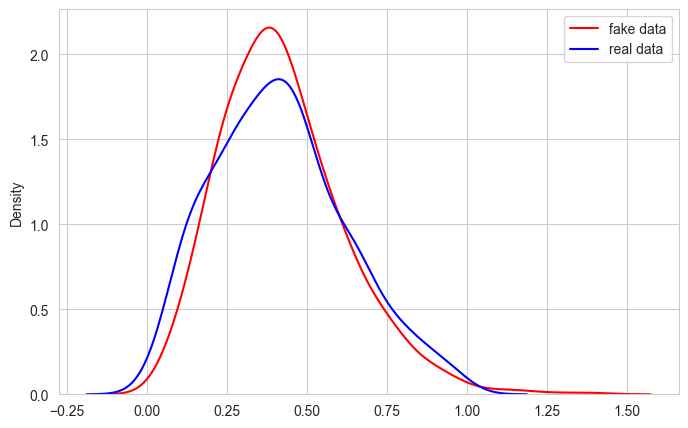

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# 학습 완료 후 데이터 분포 시각화
z = makeZ(m=real_data.shape[0], n=g_input)
fake_data = G.predict(z)

plt.figure(figsize=(8, 5))

sns.set_style('whitegrid')
sns.kdeplot(fake_data[:, 0], color='red', bw_method=0.3, label='fake data')
sns.kdeplot(real_data.reshape(-1,1)[:, 0], color='blue', bw_method=0.3, label='real data')

plt.legend()

plt.show()

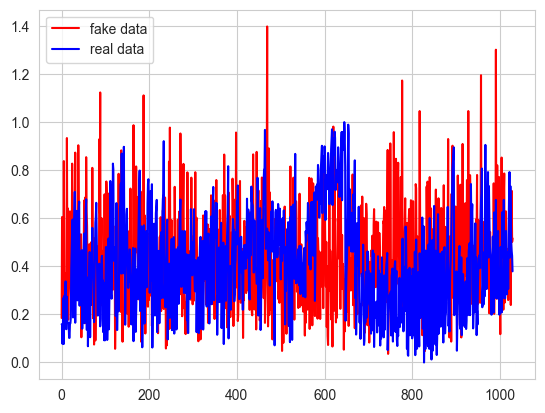

In [14]:
plt.plot(fake_data[:, 0], color='red', label='fake data')
plt.plot(real_data.reshape(-1,1)[:, 0], color='blue', label='real data')

plt.legend()

plt.show()

In [15]:
from sklearn.metrics import mean_squared_error

real_data = sc.inverse_transform(real_data)
fake_data = sc.inverse_transform(fake_data)

print(mean_squared_error(real_data, fake_data))
print(np.sqrt(mean_squared_error(real_data, fake_data)))

531.2697337607087
23.04928922463139


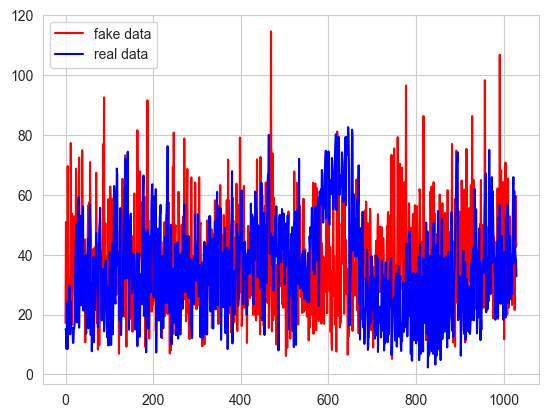

In [16]:
plt.plot(fake_data[:, 0], color='red', label='fake data')
plt.plot(real_data.reshape(-1,1)[:, 0], color='blue', label='real data')

plt.legend()

plt.show()